In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import tensorflow as tf
import scipy.sparse as sp
import scipy
from itertools import chain, combinations
import pandas as pd
import matplotlib.cm as cm
from nilearn import plotting
import nilearn
from scipy.stats import spearmanr

In [2]:
DATA_FOLDER = 'data/'

In [3]:
# classification

def sp_matrix_to_sp_tensor(M):
    if not isinstance(M, sp.csr.csr_matrix):
        M = M.tocsr()
    row, col = M.nonzero()
    batch = np.zeros(row.shape[0])
    X = tf.SparseTensor(np.mat([batch, row, col]).T, M.data, (1,) + M.shape)
    X = tf.cast(X, tf.float32)
    return X

def classify(model,masked_graph,nodes_per_graph):  
    sparse_adj = sp_matrix_to_sp_tensor(nx.to_scipy_sparse_matrix(masked_graph))
    fake_eye = tf.SparseTensor(np.mat([np.zeros(nodes_per_graph), np.arange(nodes_per_graph), \
                np.arange(nodes_per_graph)]).T, np.ones(nodes_per_graph, dtype=np.float32), \
                            (1,nodes_per_graph,nodes_per_graph))
    raw = model([sparse_adj,fake_eye]).numpy()[0]
    c1_prob = scipy.special.softmax(raw)[1]
    return c1_prob

def batch_classify(model,graphs,nodes_per_graph):
    sparse_adj = tf.sparse.concat(0,[sp_matrix_to_sp_tensor(nx.to_scipy_sparse_matrix(g)) for g in graphs])
    fake_eye = tf.SparseTensor(np.mat([np.zeros(nodes_per_graph), np.arange(nodes_per_graph), \
                np.arange(nodes_per_graph)]).T, np.ones(nodes_per_graph, dtype=np.float32), \
                            (1,nodes_per_graph,nodes_per_graph))
    all_eye = tf.sparse.concat(0,[fake_eye for _ in graphs])
    raw = model([sparse_adj,fake_eye]).numpy()
    c1_prob = np.array([scipy.special.softmax(line)[1] for line in raw])
    return c1_prob

In [4]:
# masking

def mask_motif_set(graph,motifs,mask_mode):
    edges = set([a for b in [[tuple(sorted(e)) for e in m.edges] for m in motifs] for a in b])
    if mask_mode == 'remove':
        return remove_motifs(graph,edges)
    if mask_mode == 'toggle':
        return toggle_motifs(graph,edges)
    if mask_mode == 'blur':
        return blur_motifs(graph,edges)
    else:
        print('unknown mask mode')

def remove_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        if tmp.has_edge(n1,n2):
            tmp.remove_edge(n1,n2)
    return tmp

def toggle_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        if tmp.has_edge(n1,n2):
            tmp.remove_edge(n1,n2)
        else:
            tmp.add_edge(n1,n2)
    return tmp

def blur_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        tmp.add_edge(n1,n2)
        tmp[n1][n2]['weight'] = avg_graph_density
    return tmp

In [5]:
# lattice

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def pascaline(n):
    "pascaline(5) -> [1, 4, 6, 4, 1]"
    n -= 1
    line = [1]
    for k in range(max(n,0)):             
        line.append(line[k]*(n-k)//(k+1))             
    return line

def build_lattice(bbox,datapoint,nodes_per_graph,motifs,mask_mode):
    lattice_nodes = {}
    for team in powerset(enumerate(motifs)):
        indxs = tuple(indx for (indx,m) in team)
        motifs_team = [m for (indx,m) in team]
        masked_graph = mask_motif_set(datapoint,motifs_team,mask_mode)
        outp = classify(bbox,masked_graph,nodes_per_graph)
        local_dict = {'motifs':motifs_team,'masked':masked_graph,'outp':outp}
        lattice_nodes[indxs] = local_dict
    return lattice_nodes

def batch_build_lattice(bbox,graphs,nodes_per_graph,motifs,mask_mode):
    lattice_nodes = {}
    tmp_len = 0
    for team in powerset(enumerate(motifs)):
        if len(team)>tmp_len:
            print(len(team),end=' ')
            tmp_len+=1
        indxs = tuple(indx for (indx,m) in team)
        motifs_team = [m for (indx,m) in team]
        masked_graphs = [mask_motif_set(g,motifs_team,mask_mode) for g in graphs]
        outp = batch_classify(bbox,masked_graphs,nodes_per_graph)
        lattice_nodes[indxs] = outp
    print()
    return lattice_nodes

In [6]:
# shapley

def get_shapley_values(lattice,motifs):
    shap_dict = {}
    for indx,motif in enumerate(motifs):
        mnope = powerset([x for x in range(len(motifs)) if x!=indx])
        mwith = [tuple(sorted([*team,indx])) for team in mnope]
        raw_shapley = [lattice[mno]['outp']-lattice[myes]['outp'] for mno,myes in list(zip(mnope,mwith))]
        pascal = pascaline(len(motifs))
        coef = [1./len(motifs)/pascal[len(key)] for key in mnope]
        shapley = np.dot(coef,raw_shapley)
        shap_dict[indx] = shapley
    return shap_dict

def batch_get_shapley_values(lattice,motifs):
    shap_dict = {}
    for indx,motif in enumerate(motifs):
        mnope = powerset([x for x in range(len(motifs)) if x!=indx])
        mwith = [tuple(sorted([*team,indx])) for team in mnope]
        diff = [lattice[mno]-lattice[myes] for mno,myes in list(zip(mnope,mwith))]
        pascal = pascaline(len(motifs))
        coef = [1./len(motifs)/pascal[len(key)] for key in mnope]
        shap_weighted_margins = [c*sh for c,sh in zip(coef,diff)]
        shap_values = np.sum(np.array(shap_weighted_margins),axis=0)
        shap_dict[indx] = shap_values
    return shap_dict

In [7]:
# motif utils

def make_motif_names(info):
    initials = info[::2]
    counts = info[1::2]
    return [a for b in [[init+str(i) for i in range(count)] for init,count in zip(initials,counts)] for a in b]

def edgelist_to_nx(edgelists):
    motifs = []
    for edgelist in edgelists:
        tmp = nx.empty_graph()
        for (n1,n2) in edgelist:
            tmp.add_edge(n1,n2)
        motifs.append(tmp)
    return motifs

def subgraph_status(big,small):
    matches = [e in big.edges for e in small.edges]
    if all(matches):
        return 'OK'
    elif all(np.logical_not(matches)):
        return 'KO'
    else:
        return '??'
    
def contains_motif(graph,motif):
    occurring = [e in graph.edges for e in motif.edges]
    return 'completely occurring' if all(occurring) else 'not occurring' \
            if all(np.logical_not(occurring)) else 'partially occurring'

In [8]:
# reporting

def motifs_analysis(bbox,datapoint,true_label,shaps,motifs,mnames,injected=False):
    pred = int(classify(bbox,datapoint,nodes_per_graph)>.5)
    if true_label!=pred:
        print('element of class',true_label,'was wrongly classified as',pred)
    else:
        print('element of class',true_label,'correctly classified')
        #mtype_dict = {l:0 for l in set(mtypes)}
        for indx,motif in enumerate(motifs):
            #mtype = mtypes[indx]
            #mnum = mtype_dict[mtype]
            #mtype_dict[mtype]+=1
            print(mnames[indx],end=', ')
            if injected:
                print('motif of the','same' if indx%2==true_label else 'other','class',end=', ')
            print(contains_motif(datapoint,motif),'SHAP',shaps[indx])

def graphshap_analysis(bbox,datapoint,true_label,motifs,mnames,mask_mode,nodes_per_graph,injected=False):
    lattice = build_lattice(bbox,datapoint,nodes_per_graph,motifs,mask_mode)
    shaps = get_shapley_values(lattice,motifs)
    motifs_analysis(bbox,datapoint,true_label,shaps,motifs,mnames,injected)
    return shaps

In [9]:
# plotting/1

def display_motifs(mined,injected,random,ncols):
    #
    nrows = int(np.ceil((len(random)+1)/ncols)) + \
            int(np.ceil((len(injected)+1)/ncols)) + \
            int(np.ceil((len(mined)+1)/ncols))
    plt.figure(figsize=(3*ncols,3*nrows))
    countr = 1
    for indxd,dataset in enumerate([mined,injected,random]):
        name = ['Mnd','Inj','Rnd'][indxd]
        ncol = ['gold','limegreen','dodgerblue'][indxd]
        for indx,motif in enumerate(dataset):
            plt.subplot(nrows,ncols,countr)
            countr+=1
            nx.draw_networkx(motif,node_color=ncol)
            plt.xticks([],[])
            plt.yticks([],[])
            plt.title(name+'_'+str(indx))
    plt.tight_layout()

In [10]:
# plotting/2

def violin_plot(ax, shaps, widths=0.2):
    nmotifs = len(shaps)
    labels = []
    max_shap = max([abs(a) for b in list(shaps.values()) for a in b])
    positions = range(6)
    c0_data = [shaps[i][:100] for i in list(shaps.keys())]
    return ax.violinplot(c0_data, list(shaps.keys()), widths=widths)

def plot_correlation(expected_shap,tables):  
    gshap_modes = tables.keys()
    fig, axs = plt.subplots(3,1,sharex=True, figsize=(4.5, 4.5))
    plt.tight_layout(pad=0.1)
    for i, mode in enumerate(gshap_modes):
        cor = spearmanr(tables[mode].flatten(), expected_shap.flatten())
        ax = axs.flatten()[i]
        df = pd.DataFrame({"expected": expected_shap.flatten(), 
                           "graphshap": tables[mode].flatten()}).set_index('expected')
        violin_data = {}
        for k, g in df.groupby('expected'):
            violin_data[k] = g['graphshap'].values
        v = violin_plot(ax, violin_data, widths=0.15)
        v['cmaxes'].set_linewidth(0.5)
        v['cmins'].set_linewidth(0.5)
        v['cbars'].set_linewidth(0.5)
        for b in v:
            pass
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        ax.set_ylim(-0.32, 0.32)
        ax.text(-1.1, 0.2, f"{mode.replace('blur','average')} (Spearman: {cor.correlation:.2f})")
        if i==2:
            ax.set_xlabel('Expected explanation score')
        if i==1:
            ax.set_ylabel('Distribution of explanation scores')
    fig.suptitle('')

In [11]:
# plotting/3

def plot_graphshap_scores(local_shaps,motif_type,is_local=True):
    plt.figure(figsize=(8,4))
    plt.rcdefaults()
    m_names,lshap_vals = np.array(sorted(local_shaps.items(),key=lambda x:abs(x[1]),reverse=True)).T
    y_pos = np.arange(len(m_names))
    m_names = [motif_type+str(int(i)) for i in m_names]
    #
    if is_local:
        colors = ['orangered' if v<0 else 'dodgerblue' for v in lshap_vals]
    else:
        colors = ['limegreen' for v in lshap_vals]
    plt.bar(y_pos, lshap_vals, align='center', alpha=0.5, color=colors)
    #
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines["bottom"].set_position(("data", 0))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    label_offset = 0.005
    for m_name, (x_position, y_position) in zip(m_names, enumerate(lshap_vals)):
        if y_position > 0:
            label_y = -label_offset
        else:
            label_y = 2*label_offset
        ax.text(x_position, label_y, m_name, ha="center", va="top")
    ax.text(0.5, -0.05, "Motifs selected for explanation", ha="center", va="top", transform=ax.transAxes)
    plt.ylabel('Explanation scores');   

In [12]:
# plotting/4

def plot_motifs_brain_colored(mined_edgelist,brain_coord):
    baseone_motifs = [tuple([(v1+1,v2+1) for v1,v2 in m]) for m in mined_edgelist]
    colors = dict(zip(sorted(set(brain_coord['area'].values))[::-1],cm.rainbow(np.linspace(0, 1, 8))))
    color_dict = {i:colors[brain_coord.loc[i]['area']] for i in range(1,116)}
    plt.figure(figsize=(15,7))
    for k in range(10):
        plt.subplot(2,5,k+1)
        tmp = nx.empty_graph()
        for a,b in baseone_motifs[k]:
            tmp.add_edge(a,b)
        nx.draw_networkx(tmp,node_color=[color_dict[n] for n in tmp])
        plt.title('M'+str(k))
    plt.tight_layout()

def brainplot_motif(motif,brain_coord):
    adj = np.zeros((116,116))
    for a,b in motif.edges:
        adj[a,b] = 1
        adj[b,a] = 1
    nilearn.plotting.plot_connectome(adj,brain_coord,display_mode='lyrz',node_kwargs={'alpha':.25},
            node_size = 10, edge_kwargs={'linewidth':2,'color':'b'});

# Experiment 5.2

In [13]:
EXP_NAME = 'exp52'

In [14]:
graphs_0 = pickle.load(open(DATA_FOLDER+'synth_'+EXP_NAME+'_0','rb'))
graphs_1 = pickle.load(open(DATA_FOLDER+'synth_'+EXP_NAME+'_1','rb'))
graphs = graphs_0+graphs_1
assert len(set([len(g) for g in graphs])) == 1
nodes_per_graph = len(graphs[0])
assert len(graphs_0)==len(graphs_1)
graphs_per_class = len(graphs_0)
avg_graph_density = np.mean([len(g.edges)/(nodes_per_graph*nodes_per_graph) for g in graphs])
labels = [0]*len(graphs_0)+[1]*len(graphs_1)
#
mined = []
injected = pickle.load(open(DATA_FOLDER+'injected_'+EXP_NAME,'rb'))
random = []
motif_names = make_motif_names(['I',len(injected)])
#
bbox = tf.keras.models.load_model(DATA_FOLDER+'gcnn_'+'synth_'+EXP_NAME)
print('bbox:',sum((batch_classify(bbox,graphs,nodes_per_graph)>.5)==labels),'over',len(labels))

bbox: 191 over 200


In [15]:
%%time
global_lattice_remove = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='remove')
global_shaps_remove = batch_get_shapley_values(global_lattice_remove,injected)

1 2 3 4 5 6 
CPU times: user 4min 19s, sys: 4.27 s, total: 4min 23s
Wall time: 1min 41s


In [16]:
table1 = np.array([[prob,np.mean(global_shaps_remove[indx])] for indx,prob in enumerate([0,.2,.4,.6,.8,1])])
pd.DataFrame(table1.T,index=['Perturbation_probability','Average_explanation_score'],\
             columns=['M'+str(i) for i in range(6)])

,M0,M1,M2,M3,M4,M5
Perturbation_probability,0.000000,0.200000,0.400000,0.600000,0.800000,1.000000
Average_explanation_score,-0.005767,0.014019,-0.031241,0.066047,-0.067394,0.095368


# Experiment 5.3

In [17]:
%%time
#
global_lattice_remove = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='remove')
global_shaps_remove = batch_get_shapley_values(global_lattice_remove,injected)
#
global_lattice_toggle = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='toggle')
global_shaps_toggle = batch_get_shapley_values(global_lattice_toggle,injected)
#
global_lattice_blur = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='blur')
global_shaps_blur = batch_get_shapley_values(global_lattice_blur,injected)

1 2 3 4 5 6 
1 2 3 4 5 6 
1 2 3 4 5 6 
CPU times: user 13min 11s, sys: 13 s, total: 13min 24s
Wall time: 5min 10s


In [18]:
def get_correlation_data(graphs,motifs,global_shaps_remove,global_shaps_blur,global_shaps_toggle):
    forced_motifs = []
    for indx,g in enumerate(graphs):
        forced_motifs.append([subgraph_status(g,m) for m in motifs])
    forced_motifs = np.array(forced_motifs)
    forced_motifs_val = np.zeros(forced_motifs.shape)
    forced_motifs_val += (forced_motifs == 'OK')
    forced_motifs_val -= (forced_motifs == 'KO')
    #
    target = [-1]*graphs_per_class + [1]*graphs_per_class
    prob = np.array([[0,.2,.4,.6,.8,1]]*(graphs_per_class*2))
    motif_class = np.array([[-1,1,-1,1,-1,1]]*(graphs_per_class*2))
    expected_shap = (forced_motifs_val*prob*motif_class)
    #
    shap_table_remove = np.stack([global_shaps_remove[mi] for mi in range(6)]).T
    shap_table_blur = np.stack([global_shaps_blur[mi] for mi in range(6)]).T
    shap_table_toggle = np.stack([global_shaps_toggle[mi] for mi in range(6)]).T
    tables = dict(zip(['remove', 'blur', 'toggle'],[shap_table_remove,shap_table_blur,shap_table_toggle]))
    #
    return expected_shap,tables

In [19]:
expected_shap,tables = get_correlation_data(graphs,injected,\
                                            global_shaps_remove,global_shaps_blur,global_shaps_toggle)

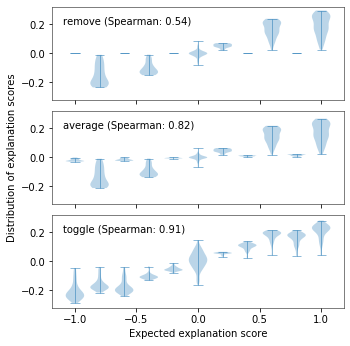

In [20]:
plot_correlation(expected_shap,tables)

# Experiment 5.4

In [21]:
EXP_NAME = 'eyesclosed'

In [22]:
td = pickle.load(open(DATA_FOLDER+EXP_NAME+'_td','rb'))
asd = pickle.load(open(DATA_FOLDER+EXP_NAME+'_asd','rb'))
graphs = td+asd
assert len(set([len(g) for g in graphs])) == 1
nodes_per_graph = len(graphs[0])
avg_graph_density = np.mean([len(g.edges)/(nodes_per_graph*nodes_per_graph) for g in graphs])
labels = [0]*len(td)+[1]*len(asd)
#
mined_edgelist = pickle.load(open(DATA_FOLDER+'mined_ranked_'+EXP_NAME,'rb'))
mined = edgelist_to_nx(mined_edgelist)
injected = []
random = []
motif_names = make_motif_names(['M',len(mined)])
#
bbox = tf.keras.models.load_model(DATA_FOLDER+'gcnn_'+EXP_NAME)
print('bbox:',sum((batch_classify(bbox,graphs,nodes_per_graph)>.5)==labels),'over',len(labels))

bbox: 276 over 294


In [23]:
brain_coord = pd.read_csv(DATA_FOLDER+'coordinates.csv',index_col=0,header=None,sep=';')
brain_coord.columns = ['name','area','x','y','z']

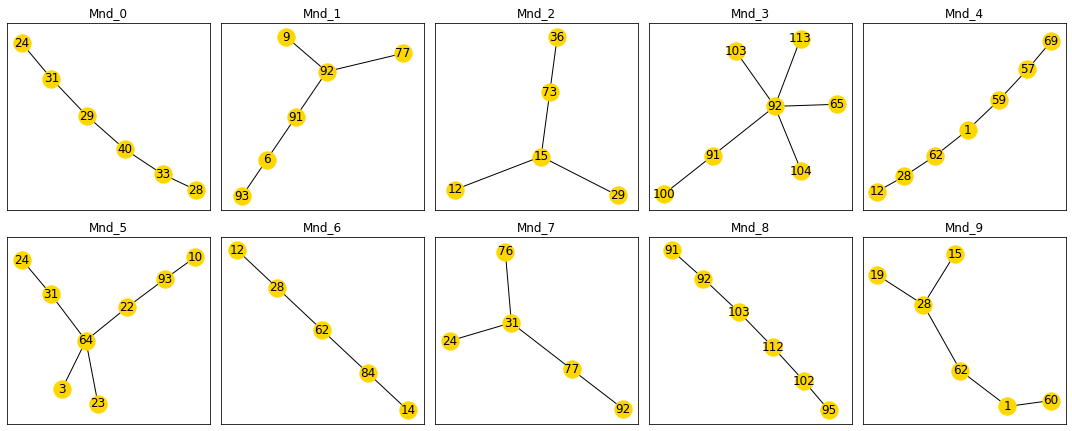

In [24]:
#0-indexed for internal use
display_motifs(mined,injected,random,5)

In [25]:
indx = 181
mined_shaps = graphshap_analysis(bbox,graphs[indx],labels[indx],\
                                 mined,motif_names,'toggle',nodes_per_graph,injected=False)

element of class 1 correctly classified
M0, partially occurring SHAP 0.03890109690172332
M1, partially occurring SHAP 0.03392364089451139
M2, partially occurring SHAP 0.07841674090614395
M3, partially occurring SHAP 0.06769981493079473
M4, partially occurring SHAP -0.08281905885253635
M5, not occurring SHAP 0.10530167872470524
M6, partially occurring SHAP 0.006768435594581422
M7, not occurring SHAP 0.05243531898373649
M8, partially occurring SHAP -0.04744514709427243
M9, partially occurring SHAP 0.009557763215095279


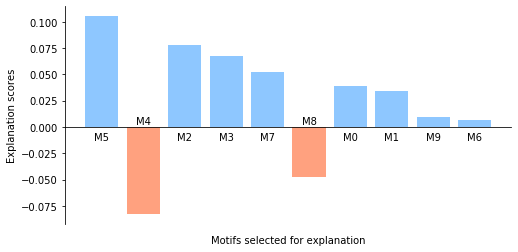

In [26]:
plot_graphshap_scores(mined_shaps,'M',is_local=True)

In [27]:
global_lattice_toggle = batch_build_lattice(bbox,graphs,nodes_per_graph,mined,mask_mode='toggle')
global_shaps_toggle = batch_get_shapley_values(global_lattice_toggle,mined)

1 2 3 4 5 6 7 8 9 10 


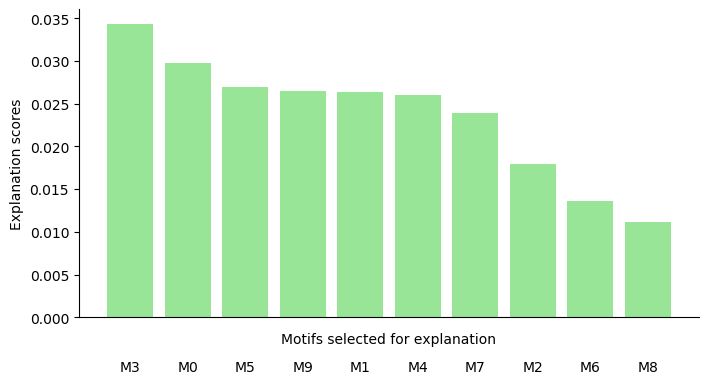

In [28]:
mean_abs_shaps = dict(zip(range(10),[np.mean(abs(global_shaps_toggle[k])) for k in range(10)]))
plot_graphshap_scores(mean_abs_shaps,'M',is_local=False)

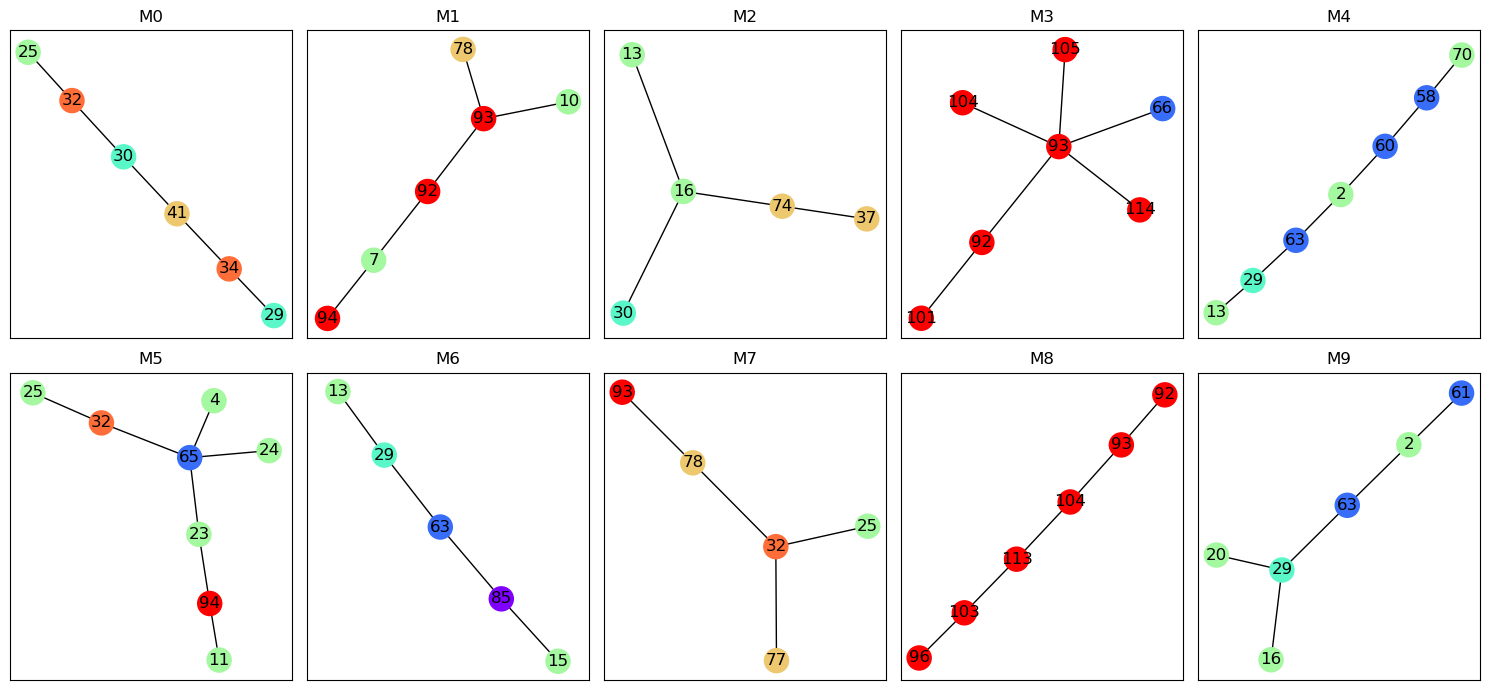

In [29]:
#one-indexed for AAL standards, brain-area color-coded
plot_motifs_brain_colored(mined_edgelist,brain_coord)

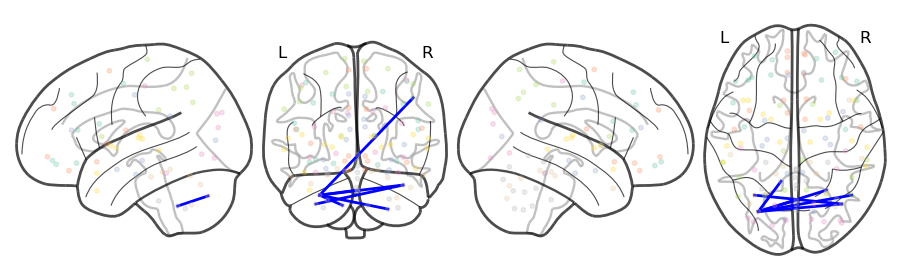

In [30]:
brainplot_motif(mined[3],brain_coord.values[:,-3:])